In [2]:
using SerialPorts
using PyPlot
using FFTW

In [3]:
# #=================================================================
# Empty array
# =================================================================#

# dummy_one = open("dummy1.txt") do file
#     read(file, String)
# end

# dummy_two = open("dummy2.txt") do file
#     read(file, String)
# end

# dummy_array_one=split(dummy_one, (", "))

# dummy_array_two = split(dummy_two, (", "))

# #=================================================================#

# da1 = []
# da2 = []

# for i in dummy_array_one
#     if (i == "")
#         continue
#     end
# #     println(i)
#     push!(da1,parse(Int,i))
# end

# for i in dummy_array_two
#     if (i == "")
#         continue
#     end
#     push!(da2,parse(Int,i))
# end

# DummyOne = (3.3/4096).*da1
# DummyTwo = (3.3/4096).*da2


In [4]:
#=================================================================
 Processing constants
=================================================================#
c = 343;          # Speed of sound in air in m/s
fs = 500000;       # This is the sample rate of the sonar.
dt = 1/fs;        # This is the sample spacing
r_max = 12;        # Maximum range in metres to which to simulate.
t_max = 2*r_max/c;

t = collect(0:dt:t_max);
println(length(t))

r = c*t/2;

f0 = 40000;       # Centre frequency is 40 kHz
B = 2000;         # Chirp bandwidth
T = 6E-3;         # Chirp pulse length
K = B/T;          # Chirp rate
N = length(r)

34986


34986

In [5]:
#=================================================================#
# BPF

function rect(t)
    N = length(t)
    x = zeros(N)
    for n = 1:N
        abs_t = abs(t[n])
        if abs_t > 0.5
            x[n] = 0.0
        elseif abs_t < 0.5
            x[n] = 1.0
        else
            x[n] = 0.5
        end
    end
    return x
end

δt = dt
δω = 2*pi/(N*dt)

ω = 0:δω:(N-1)*δω
f = ω/2*pi

ω0 = f0*2*pi

H = rect((ω.-ω0)/(2*pi*1000))+rect((ω.-(ω0.- 2*pi/δt))/(2*pi*1000))


34986-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮  
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [6]:
#=================================================================
Match filter option 1
=================================================================#
# matched_one = open("Filter1.txt") do file
#     read(file, String)
# end
#
# matched_two = open("Filter2.txt") do file
#     read(file, String)
# end
#
# array_one=split(matched_one, (", "))
#
# array_two = split(matched_two, (", "))
#
# #=================================================================#
# ma1 = []
# ma2 = []
#
# for i in array_one
#     if (i == "")
#         continue
#     end
#     push!(ma1,parse(Int,i))
# end
#
# for i in array_two
#     if (i == "")
#         continue
#     end
#     push!(ma2,parse(Int,i))
# end
#
# MatchOne = (3.3/4096).*ma1
# MatchTwo = (3.3/4096).*ma2
#
# for j = 1:length(MatchOne)
#     MatchOne[j]=MatchOne[j]-DummyOne[j]
#     MatchTwo[j]=MatchTwo[j]-DummyTwo[j]
# end


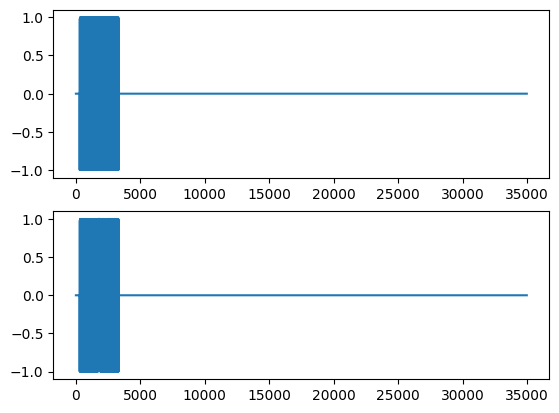

30000
34986
34986


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f952d035e80>

In [7]:
#=================================================================
Match Filter option 2
=================================================================#
rect(t) = (abs.(t) .<= 0.5)*1.0
td = 0.6*T;   # Chirp delay
v_tx = cos.( 2*pi*(f0*(t .- td) + 0.5*K*(t .- td).^2) ) .* rect.((t .-td)/T);

v_tx = v_tx[1:30000]
println(length(v_tx));

for i = 1:4986
    push!(v_tx,0)
end

MatchOne = v_tx
MatchTwo = v_tx

println(length(MatchOne))
println(length(MatchTwo))

#=================================================================#

figure("Expected Echo")
title("Expected Echo")
subplot(2,1,1)
plot(MatchOne)
subplot(2,1,2)
plot(MatchTwo) #query

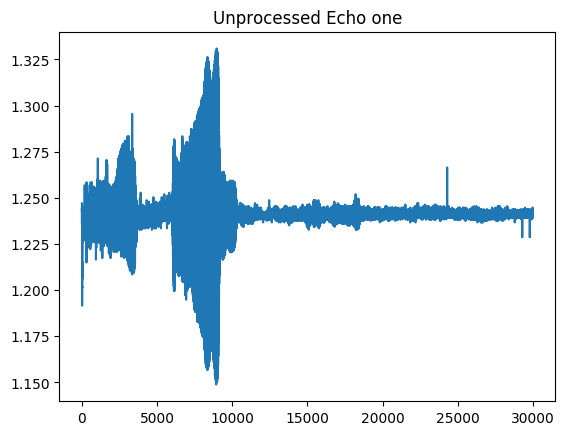

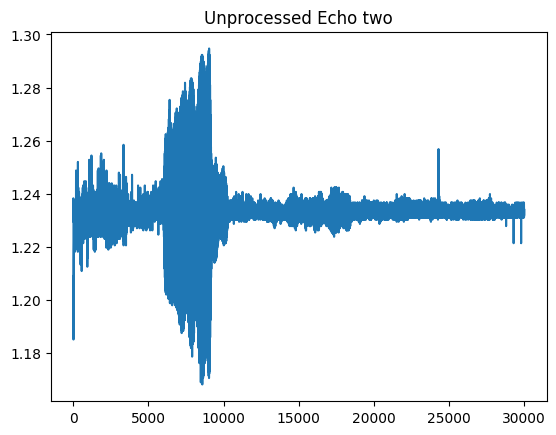

30000
30000


In [133]:
#=================================================================
Receiving prcess
=================================================================#

receive_one = []
receive_two = []

list= list_serialports()
# ser = SerialPort("COM3:", 9600)
ser = SerialPort(list[1], 9600)

readavailable(ser)

#transmit and receive
write(ser, "c")

while bytesavailable(ser) < 1
    continue
end

sleep(0.05)
readavailable(ser) #removes the conversion complete line

#=================================================================#
# Get the first buffer
b = ""
readavailable(ser)

write(ser, "a") # Print DMA buffer
while bytesavailable(ser) < 1
    continue # wait for a response
end

while true
    if bytesavailable(ser) < 2
        sleep(0.005) # Wait and check again
        if bytesavailable(ser) < 1
            break
        end
    end

    global b = string(b, readavailable(ser))

end

receive_one=split(b, ("\r\n"))

#=================================================================#
# Get the second buffer
b = ""
readavailable(ser)

write(ser, "b") # Print DMA buffer
while bytesavailable(ser) < 1
    continue # wait for a response
end

while true
    if bytesavailable(ser) < 2
        sleep(0.005) # Wait and check again
        if bytesavailable(ser) < 1
            break
        end
    end

    b = string(b, readavailable(ser))

end

close(ser)

receive_two=split(b, ("\r\n"))

#=================================================================#
rc1 = []
rc2 = []

i=1

while (i<length(receive_one))
    push!(rc1,parse(Int,(receive_one[i])))
    global i+=1
end

global i=1

while (i<length(receive_two))
    push!(rc2,parse(Int,(receive_two[i])))
    global i+=1
end

echo_one = (3.3/4096).*rc1
echo_2 = (3.3/4096).*rc2

# for j = 1:length(echo_one)
#     echo_one[j]=echo_one[j]-DummyOne[j]
#     echo_2[j]=echo_2[j]-DummyTwo[j]
# end

figure("Unprocessed Echo one")
title("Unprocessed Echo one")
plot(echo_one)

figure("Unprocessed Echo two")
title("Unprocessed Echo two")
plot(echo_2)

println(length(echo_one))
println(length(echo_2))

#end of receiving

In [134]:
#=================================================================#
for i = 0:4985
    push!(echo_one,echo_one[29999])
    push!(echo_2,echo_2[29999])
end

println(length(echo_2))
println(length(echo_2))

34986
34986


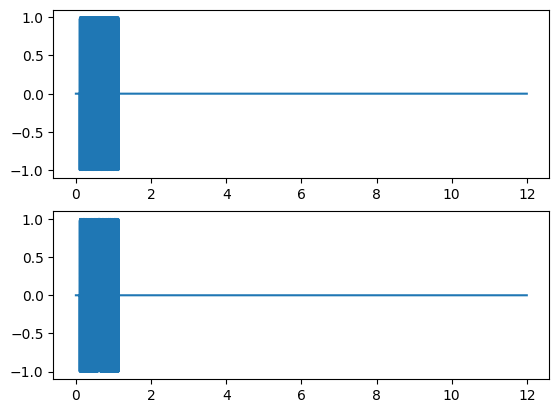

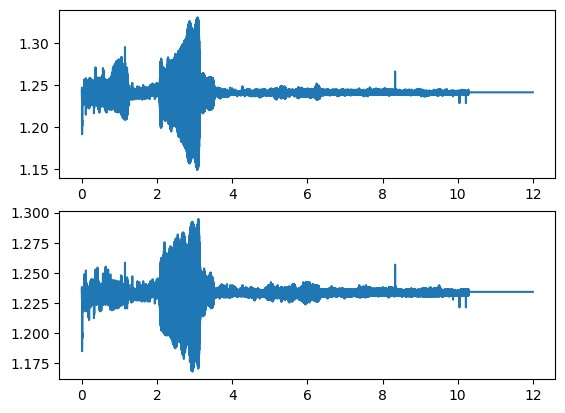

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f951a123358>

In [135]:
#=================================================================
The signals
=================================================================#
#"expected echoes"
v_tx1 = MatchOne
V_TX1 = fft(v_tx1);

v_tx2 = MatchTwo
V_TX2 = fft(v_tx2);

# received echos
v_rx1 = echo_one
V_RX1 = H.*(fft(v_rx1));

v_rx2 = echo_2
V_RX2 = H.*(fft(v_rx2));


#plots
figure("Expected Echo")
title("Expected Echo")
subplot(2,1,1)
plot(r,v_tx1)
subplot(2,1,2)
plot(r,v_tx2) #query

#plots
figure("Unprocessed Received Echo")
title("Unprocessed Received Echo")
subplot(2,1,1)
plot(r,v_rx1)
subplot(2,1,2)
plot(r,v_rx2) #query


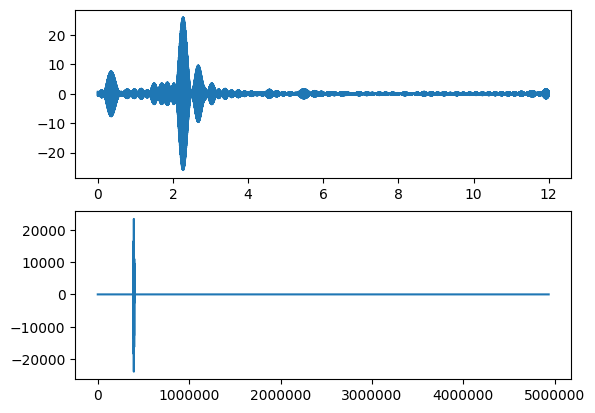

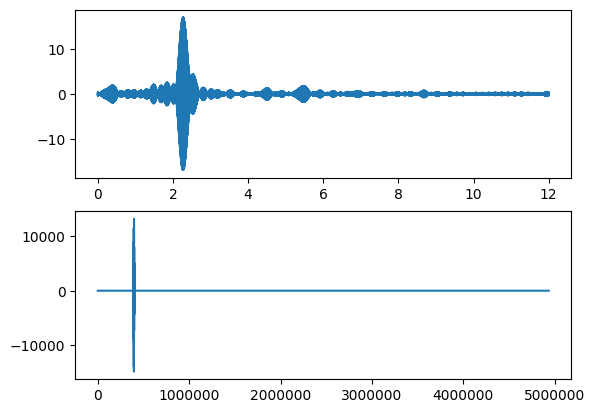

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f950e17d9e8>

In [136]:
#=================================================================
Matched Filering
=================================================================#
#filter one
H1 = conj( V_TX1);

V_MF1 = H1.*V_RX1;
v_mf1 = ifft(V_MF1);

#Filter two
H2 = conj(V_TX2);

V_MF2 = H2.*V_RX2;
v_mf2 = ifft(V_MF2);

#plots
figure("First Echo match filtered")
title("First Echo match filtered")
subplot(2,1,1)
plot(r,v_mf1)
subplot(2,1,2)
plot(f,V_MF1) #query

#plots
figure("second Echo match filtered")
title("second Echo match filtered")
subplot(2,1,1)
plot(r,v_mf2)
subplot(2,1,2)
plot(f,V_MF2) #query

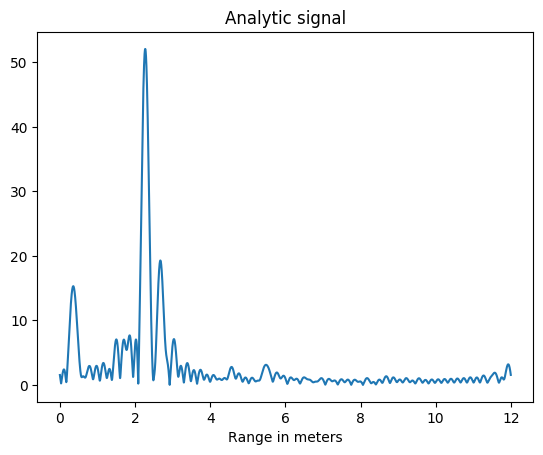

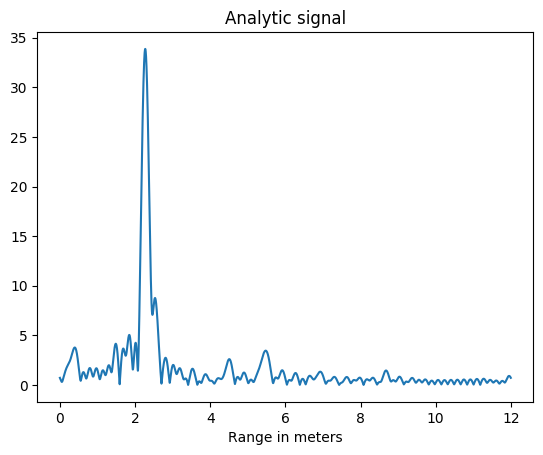

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f950ea58d30>

In [137]:
#=================================================================
Analytic Signal
=================================================================#

V_ANAL1 = 2*V_MF1; # make a copy and double the values

if mod(N,2)==0 # case N even
    neg_freq_range = Int(N/2):N; # Define range of “neg-freq” components
else # case N odd
    neg_freq_range = Int((N+1)/2):N;
end

V_ANAL1[neg_freq_range] .= 0; # Zero out neg components in 2nd half of array.
v_anal1 = ifft(V_ANAL1);

#Analytic echo 2

V_ANAL2 = 2*V_MF2; # make a copy and double the values

if mod(N,2)==0 # case N even
    neg_freq_range = Int(N/2):N; # Define range of “neg-freq” components
else # case N odd
    neg_freq_range = Int((N+1)/2):N;
end

V_ANAL2[neg_freq_range] .= 0; # Zero out neg components in 2nd half of array.
v_anal2 = ifft(V_ANAL2);

figure()
title("Analytic signal")
xlabel("Range in meters")
plot(r,abs.(v_anal1))

figure()
title("Analytic signal")
xlabel("Range in meters")
plot(r,abs.(v_anal2))

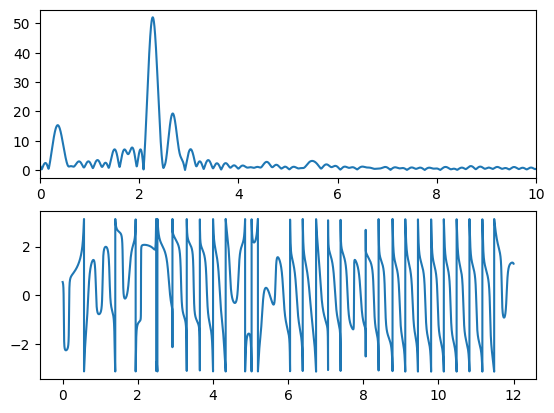

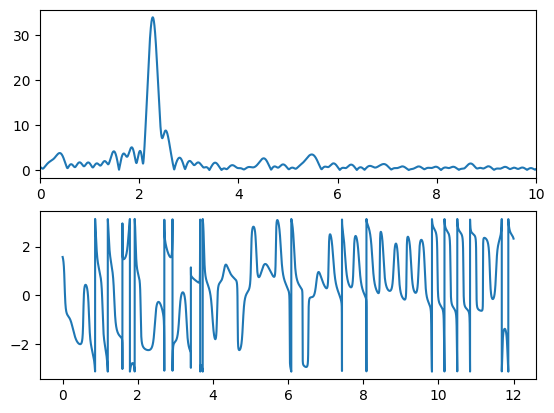

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f950eca8e80>

In [170]:
#=================================================================
Base band Signals
=================================================================#
j=im;

v_bb1 = v_anal1.*exp.(-j*2*pi.*f0.*t);
V_BB1 = fft(v_bb1);

v_bb2 = v_anal2.*exp.(-j*2*pi*f0.*t);
V_BB2 = fft(v_bb2);

#plots
figure("Base band signal 1")
title("Base band signal 1")
subplot(2,1,1)
plot(r,abs.(v_bb1))
xlim(0,10)
subplot(2,1,2)
plot(r,angle.(v_bb1))


#plots
figure("Base band signal 2")
title("Base band signal 2")
subplot(2,1,1)
plot(r,abs.(v_bb2))
xlim(0,10)
subplot(2,1,2)
plot(r,angle.(v_bb2))


In [149]:
#=================================================================
Angle Calculation
=================================================================#
d = 0.01778
k = [-1,0,1]
λ = c/f0

Δψ = angle.( v_bb2 .* conj(v_bb1))
θa = asin.((λ/(2*pi*d)).* (Δψ.+(k[1]*2*pi)))
θb = asin.((λ/(2*pi*d)).* (Δψ.+(k[2]*2*pi)))
θc = asin.((λ/(2*pi*d)).* (Δψ.+(k[3]*2*pi)))

xa = r.*cos.(θa)
ya = r.*sin.(θa)

xb = r.*cos.(θb)
yb = r.*sin.(θb)

xc = r.*cos.(θc)
yc = r.*sin.(θc)

34986-element Array{Float64,1}:
 0.0                   
 0.00019251427460709194
 0.0003849964571606531 
 0.0005774476059331828 
 0.000769868861886711  
 0.0009622614546301103 
 0.001154626708813603  
 0.0013469660509959026 
 0.0015392810170226214 
 0.0017315732599580851 
 0.0019238445586165828 
 0.0021160968267433205 
 0.0023083321229000835 
 ⋮                     
 6.741146273862844     
 6.740668007203402     
 6.740195527331149     
 6.739729186907262     
 6.739269358619649     
 6.738816436301535     
 6.738370836120049     
 6.737932997839805     
 6.737503386166746     
 6.737082492178088     
 6.736670834844478     
 6.736268962651177     

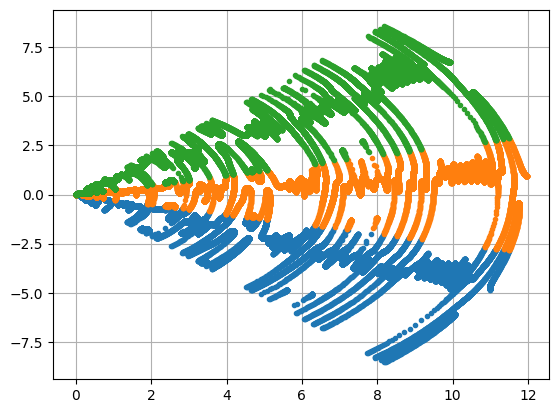

In [150]:
plot(xa,ya, ".")
plot(xb,yb, ".")
plot(xc,yc, ".")
grid("on")

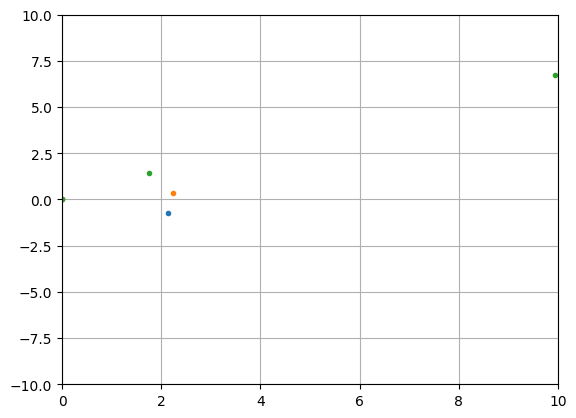

2.27066


(0, 10)

In [165]:
for n in 2:length(v_bb1)-1
    prev = abs.(v_bb1[n-1])
    next = abs.(v_bb1[n+1])
    current = abs.(v_bb1[n])
    
    if current>prev && current>next && current>20
       #doest have to do anything
        println(r[n])
    else
        # if not a target then plot off screen
        ya[n]=100
        yb[n]=100
        yc[n]=100
        
    end
    
end

plot(xa,ya, ".")
plot(xb,yb, ".")
plot(xc,yc, ".")
grid("on")
ylim(-10,10)
xlim(0,10)

In [31]:
fig = figure("Angle")
ax = axes(polar="true") # Create a polar axis
# Do your plotting

# Optional changes
ax.set_thetagrids(collect(0:dtheta:360-dtheta)) # Show grid lines from 0 to 360 in increments of dtheta
ax.set_theta_zero_location("N") # Set 0 degrees to the top of the plot
ax.set_theta_direction(-1) # Switch to clockwise
fig.canvas.draw() # Update the figure

ErrorException: function axes does not accept keyword arguments

In [34]:
findmax(v_mf2)

MethodError: MethodError: no method matching isless(::Complex{Float64}, ::Complex{Float64})
Closest candidates are:
  isless(!Matched::Missing, ::Any) at missing.jl:66
  isless(!Matched::PyCall.PyObject, ::Any) at /home/myneighbour/.julia/packages/PyCall/ttONZ/src/pyoperators.jl:75
  isless(::Any, !Matched::Missing) at missing.jl:67
  ...

In [ ]:
for n in 2:30000
    prev = abs.(vb_1[n-1])
    next = abs.(vb_1[n+1])
    current = abs.(vb_1[n])
    
    if && current>100
       #doest have to do anything
        
    else
        # if not a target then plot off screen
        y[n]=1000
        
    end
    
end